# Executing a Simple Quantum Circuit with Qiskit
Qiskit abstracts many aspects of the quantum compilation process, allowing us to interface with complex systems with a bit of simple python. To use Qiskit, a user would typically:
1. Create a quantum circuit
2. Transpile the circuit onto a backend of choice (either a simulated backend or real quantum hardware)
3. Execute the circuit on the chosen backend
4. Get the results of the executed quantum circuit.

It all starts with first installing the Qiskit package:

In [ ]:
pip install qiskit

In [6]:
from qiskit import QuantumCircuit
from qiskit.visualization import circuit_drawer

# 1) Lets create a simple quantum circuit.
qc = QuantumCircuit(5)
qc.h(0)
qc.cx(0,range(1,5))
qc.measure_all()
qc.draw()

┌───┐                     ░ ┌─┐            
   q_0: ┤ H ├──■────■────■────■───░─┤M├────────────
        └───┘┌─┴─┐  │    │    │   ░ └╥┘┌─┐         
   q_1: ─────┤ X ├──┼────┼────┼───░──╫─┤M├─────────
             └───┘┌─┴─┐  │    │   ░  ║ └╥┘┌─┐      
   q_2: ──────────┤ X ├──┼────┼───░──╫──╫─┤M├──────
                  └───┘┌─┴─┐  │   ░  ║  ║ └╥┘┌─┐   
   q_3: ───────────────┤ X ├──┼───░──╫──╫──╫─┤M├───
                       └───┘┌─┴─┐ ░  ║  ║  ║ └╥┘┌─┐
   q_4: ────────────────────┤ X ├─░──╫──╫──╫──╫─┤M├
                            └───┘ ░  ║  ║  ║  ║ └╥┘
meas: 5/═════════════════════════════╩══╩══╩══╩══╩═
                                     0  1  2  3  4

In [8]:
from qiskit.test.mock import FakeBoeblingen
from qiskit.compiler import transpile

# 2) Lets transpile the circuit on a simulated noisy quantum hardware backend (more on this step later).
simulated_backend = FakeBoeblingen()
transpiled_qc = transpile(qc, simulated_backend)

In [12]:
# 3) Lets execute the transpiled circuit on the simulated noisy backend
results = simulated_backend.run(transpiled_qc).result()

# Note: For more information about simulated noisy backends, please visit:
# https://qiskit.org/documentation/tutorials/simulators/2_device_noise_simulation.html

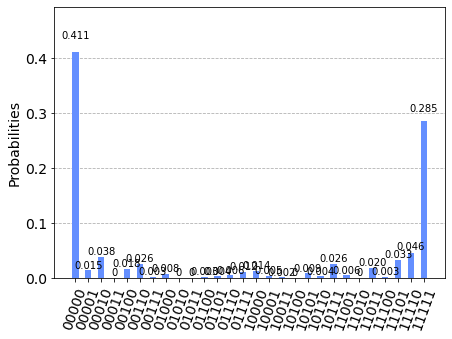

In [13]:
from qiskit.tools.visualization import plot_histogram

# 4) Lets get the results of the executed circuit
counts = results.get_counts()
plot_histogram(counts)

Here we simply created a circuit, transpiled the circuit, executed the circuit on a backend, and printed the results. A key step in that process was step 2, the transpilation. In the rest of this tutorial we will focus on the transpilation process and what goes on behind the scenes in this step. 

# Transpilation Process

The goal of the transpilation process is to injest a quantum circuit and spit out an optimized quantum circuit after having performed several transformative passes.

![Transpilation Passes](transpiling_core_steps.png)


Note: See [here](https://qiskit.org/documentation/apidoc/transpiler.html) For more information about the transpilation process.

###  Back to our example
This is exactly what we did in step 2 earlier,
```{python}
simulated_backend = FakeBoeblingen()
transpiled_qc = transpile(qc, simulated_backend)
```
The transpile function uses the ``backend`` parameter to optimize the quantum circuit according to the particular hardware the quantum circuit will be running on, therefore, the transpilation process is **"hardware aware"**.

### What other parameters does the `transpile()` function use?
The `transpile()` function has another parameter called `optimization_level`, which specifies a predefined transpilation process. As shown earlier, the transpilation process involves gate optimization, device connectivity optimization, and more - in fact, it's a somewhat daunting list. Again, Qiskit abstracts these concepts away and allows a quantum programmer to use one of four predefined transpilation processes without fiddling with the details. By default `optimization_level = 1`, but we can set it to four different values as shown here:
```{python}
simulated_backend = Aer.get_backend('aer_simulator')
transpiled_qc0 = transpile(qc, simulated_backend, optimization_level=0)  # No Optimization
transpiled_qc1 = transpile(qc, simulated_backend, optimization_level=1)  # Some Optimization
transpiled_qc2 = transpile(qc, simulated_backend, optimization_level=2)  # More Optimization
transpiled_qc3 = transpile(qc, simulated_backend, optimization_level=3)  # Maximum Optimization
```

Note: See [here](https://qiskit.org/documentation/stubs/qiskit.compiler.transpile.html) For more information about the traspiler parameters.

# Bernstein-Vazirani Circuit for 3 bit hidden string s

In [15]:
### Lets defined a new circuit of your choice with no measurements

s = '011'   # the hidden binary string
n = 3 # number of bits used to represent s


# We need a circuit with n qubits, plus one auxiliary qubit
# We also need n classical bits to write the output to
qc = QuantumCircuit(n+1, n)

# Put auxiliary in the minus state |->
# We leave the other n qubits in just |0>
qc.h(n)
qc.z(n)

# Apply Hadamard gates to each of the n "main" qubits (excluding the auxiliary)
# before querying the oracle
for i in range(n):
    qc.h(i)
    
# Apply barrier
qc.barrier()

# Apply the inner-product oracle
s = s[::-1] # reverse s to fit qiskit's qubit ordering
for q in range(n):
    if s[q] == '0':
        qc.i(q)
    else:
        qc.cx(q, n)
        
# Apply barrier
qc.barrier()

# Apply Hadamard gates after querying the oracle
for i in range(n):
    qc.h(i)

'''
# Measurement
for i in range(n):
    qc.measure(i, i)
'''

qc.draw()

┌───┐      ░                 ░ ┌───┐┌─┐      
q_0: ┤ H ├──────░───■─────────────░─┤ H ├┤M├──────
     ├───┤      ░   │             ░ ├───┤└╥┘┌─┐   
q_1: ┤ H ├──────░───┼─────────■───░─┤ H ├─╫─┤M├───
     ├───┤      ░   │  ┌───┐  │   ░ ├───┤ ║ └╥┘┌─┐
q_2: ┤ H ├──────░───┼──┤ I ├──┼───░─┤ H ├─╫──╫─┤M├
     ├───┤┌───┐ ░ ┌─┴─┐└───┘┌─┴─┐ ░ └───┘ ║  ║ └╥┘
q_3: ┤ H ├┤ Z ├─░─┤ X ├─────┤ X ├─░───────╫──╫──╫─
     └───┘└───┘ ░ └───┘     └───┘ ░       ║  ║  ║ 
c: 3/═════════════════════════════════════╩══╩══╩═
                                          0  1  2

### Optimization_level=0
This option does no optimization, so you end up using your input circuit on your hardware exactly as its been defined. This will give bad results, because your circuit does not even consider the device connectivity, there is no reduction of swap gates, etc.

In [19]:
# Define a simulated noisy backend
simulated_backend = FakeBoeblingen()

transpiled_qc0 = transpile(qc, simulated_backend, optimization_level=0)  # No Optimization
print('Optimization Level 0')
print('Depth:', transpiled_qc0.depth())
print('Gate counts:', transpiled_qc0.count_ops())
transpiled_qc0.draw()

Optimization Level 0
Depth: 12
Gate counts: OrderedDict([('cx', 11), ('u2', 7), ('barrier', 3), ('measure', 3), ('u1', 1), ('id', 1)])


┌─────────┐          ░      ┌───┐               ┌───┐     »
        q_0 -> 0 ┤ U2(0,π) ├──────────░───■──┤ X ├──■─────────■──┤ X ├──■──»
                 ├─────────┤          ░ ┌─┴─┐└─┬─┘┌─┴─┐     ┌─┴─┐└─┬─┘┌─┴─┐»
        q_1 -> 1 ┤ U2(0,π) ├──────────░─┤ X ├──■──┤ X ├──■──┤ X ├──■──┤ X ├»
                 ├─────────┤          ░ └───┘┌───┐└───┘┌─┴─┐└───┘     └───┘»
        q_2 -> 2 ┤ U2(0,π) ├──────────░───■──┤ X ├──■──┤ X ├───────────────»
                 ├─────────┤┌───────┐ ░ ┌─┴─┐└─┬─┘┌─┴─┐├───┤               »
        q_3 -> 3 ┤ U2(0,π) ├┤ U1(π) ├─░─┤ X ├──■──┤ X ├┤ I ├───────────────»
                 └─────────┘└───────┘ ░ └───┘     └───┘└───┘               »
  ancilla_0 -> 4 ──────────────────────────────────────────────────────────»
                                                                           »
  ancilla_1 -> 5 ──────────────────────────────────────────────────────────»
                                                                           »
  ancilla_2 -> 6 ──────────────────────────────────────────────────────────»
                                                                           »
  ancilla_3 -> 7 ──────────────────────────────────────────────────────────»
                                                                           »
  ancilla_4 -> 8 ──────────────────────────────────────────────────────────»
                                                                           »
  ancilla_5 -> 9 ──────────────────────────────────────────────────────────»
                                                                           »
 ancilla_6 -> 10 ──────────────────────────────────────────────────────────»
                                                                           »
 ancilla_7 -> 11 ──────────────────────────────────────────────────────────»
                                                                           »
 ancilla_8 -> 12 ──────────────────────────────────────────────────────────»
                                                                           »
 ancilla_9 -> 13 ──────────────────────────────────────────────────────────»
                                                                           »
ancilla_10 -> 14 ──────────────────────────────────────────────────────────»
                                                                           »
ancilla_11 -> 15 ──────────────────────────────────────────────────────────»
                                                                           »
ancilla_12 -> 16 ──────────────────────────────────────────────────────────»
                                                                           »
ancilla_13 -> 17 ──────────────────────────────────────────────────────────»
                                                                           »
ancilla_14 -> 18 ──────────────────────────────────────────────────────────»
                                                                           »
ancilla_15 -> 19 ──────────────────────────────────────────────────────────»
                                                                           »
            c: 3/══════════════════════════════════════════════════════════»
                                                                           »
«                       ░ ┌─────────┐ ░ ┌─┐      
«        q_0 -> 0 ──────░─┤ U2(0,π) ├─░─┤M├──────
«                       ░ ├─────────┤ ░ └╥┘┌─┐   
«        q_1 -> 1 ──■───░─┤ U2(0,π) ├─░──╫─┤M├───
«                 ┌─┴─┐ ░ └─────────┘ ░  ║ └╥┘   
«        q_2 -> 2 ┤ X ├─░─────────────░──╫──╫────
«                 └───┘ ░ ┌─────────┐ ░  ║  ║ ┌─┐
«        q_3 -> 3 ──────░─┤ U2(0,π) ├─░──╫──╫─┤M├
«                       ░ └─────────┘ ░  ║  ║ └╥┘
«  ancilla_0 -> 4 ────────────────────░──╫──╫──╫─
«                                     ░  ║  ║  ║ 
«  ancilla_1 -> 5 ────────────────────░──╫──╫──╫─
«                                     ░  ║  ║  ║ 
«  ancilla_2 -> 6 ────────────────────░──╫──╫──╫─
«     

### Optimization_level=1


In [18]:
# Define a simulated noisy backend
simulated_backend = FakeBoeblingen()

transpiled_qc1 = transpile(qc, simulated_backend, optimization_level=1)  # Some Optimization
print('Optimization Level 1')
print('Depth:', transpiled_qc1.depth())
print('Gate counts:', transpiled_qc1.count_ops())
transpiled_qc1.draw()

Optimization Level 1
Depth: 5
Gate counts: OrderedDict([('u2', 7), ('measure', 3), ('barrier', 2), ('cx', 2)])


ancilla_0 -> 0 ─────────────────────────────────────────────────
                                                                  
  ancilla_1 -> 1 ─────────────────────────────────────────────────
                                                                  
  ancilla_2 -> 2 ─────────────────────────────────────────────────
                                                                  
  ancilla_3 -> 3 ─────────────────────────────────────────────────
                                                                  
  ancilla_4 -> 4 ─────────────────────────────────────────────────
                                                                  
  ancilla_5 -> 5 ─────────────────────────────────────────────────
                                                                  
  ancilla_6 -> 6 ─────────────────────────────────────────────────
                  ┌─────────┐  ░            ░ ┌─────────┐   ┌─┐   
        q_1 -> 7 ─┤ U2(0,π) ├──░────────■───░─┤ U2(0,π) ├───┤M├───
                  └─────────┘  ░        │   ░ └─────────┘   └╥┘   
  ancilla_7 -> 8 ───────────────────────┼────────────────────╫────
                                        │                    ║    
  ancilla_8 -> 9 ───────────────────────┼────────────────────╫────
                                        │                    ║    
 ancilla_9 -> 10 ───────────────────────┼────────────────────╫────
                  ┌─────────┐  ░        │   ░ ┌─────────┐┌─┐ ║    
       q_0 -> 11 ─┤ U2(0,π) ├──░───■────┼───░─┤ U2(0,π) ├┤M├─╫────
                 ┌┴─────────┴┐ ░ ┌─┴─┐┌─┴─┐ ░ └─────────┘└╥┘ ║    
       q_3 -> 12 ┤ U2(-π,-π) ├─░─┤ X ├┤ X ├─░─────────────╫──╫────
                 └───────────┘ ░ └───┘└───┘ ░             ║  ║    
ancilla_10 -> 13 ─────────────────────────────────────────╫──╫────
                                                          ║  ║    
ancilla_11 -> 14 ─────────────────────────────────────────╫──╫────
                  ┌─────────┐  ░            ░ ┌─────────┐ ║  ║ ┌─┐
       q_2 -> 15 ─┤ U2(0,π) ├──░────────────░─┤ U2(0,π) ├─╫──╫─┤M├
                  └─────────┘  ░            ░ └─────────┘ ║  ║ └╥┘
ancilla_12 -> 16 ─────────────────────────────────────────╫──╫──╫─
                                                          ║  ║  ║ 
ancilla_13 -> 17 ─────────────────────────────────────────╫──╫──╫─
                                                          ║  ║  ║ 
ancilla_14 -> 18 ─────────────────────────────────────────╫──╫──╫─
                                                          ║  ║  ║ 
ancilla_15 -> 19 ─────────────────────────────────────────╫──╫──╫─
                                                          ║  ║  ║ 
            c: 3/═════════════════════════════════════════╩══╩══╩═
                                                          0  1  2

### Optimization_level=2


In [21]:
# Define a simulated noisy backend
simulated_backend = FakeBoeblingen()

transpiled_qc2 = transpile(qc, simulated_backend, optimization_level=2)  # More Optimization
print('Optimization Level 2')
print('Depth:', transpiled_qc2.depth())
print('Gate counts:', transpiled_qc2.count_ops())
transpiled_qc2.draw()

### Optimization_level=3


In [ ]:
# Define a simulated noisy backend
simulated_backend = FakeBoeblingen()

transpiled_qc3 = transpile(qc, simulated_backend, optimization_level=3)  # MAXIMUM Optimization!!!
print('Optimization Level 3')
print('Depth:', transpiled_qc3.depth())
print('Gate counts:', transpiled_qc3.count_ops())
transpiled_qc3.draw()

Optimization Level 3
Depth: 7
Gate counts: OrderedDict([('cx', 5), ('measure', 5), ('u2', 1), ('barrier', 1)])


░                
  ancilla_0 -> 0 ─────────────────────────────────────░────────────────
                                                      ░                
  ancilla_1 -> 1 ─────────────────────────────────────░────────────────
                                                      ░                
  ancilla_2 -> 2 ─────────────────────────────────────░────────────────
                                                      ░                
  ancilla_3 -> 3 ─────────────────────────────────────░────────────────
                                                      ░                
  ancilla_4 -> 4 ─────────────────────────────────────░────────────────
                                                      ░                
  ancilla_5 -> 5 ─────────────────────────────────────░────────────────
                                                      ░                
  ancilla_6 -> 6 ─────────────────────────────────────░────────────────
                                                      ░                
  ancilla_7 -> 7 ─────────────────────────────────────░────────────────
                                                      ░                
  ancilla_8 -> 8 ─────────────────────────────────────░────────────────
                                                      ░                
  ancilla_9 -> 9 ─────────────────────────────────────░────────────────
                                                      ░                
ancilla_10 -> 10 ─────────────────────────────────────░────────────────
                                                      ░                
ancilla_11 -> 11 ─────────────────────────────────────░────────────────
                            ┌───┐                     ░       ┌─┐      
       q_2 -> 12 ───────────┤ X ├─────────────────────░───────┤M├──────
                 ┌─────────┐└─┬─┘     ┌───┐           ░    ┌─┐└╥┘      
       q_0 -> 13 ┤ U2(0,π) ├──■────■──┤ X ├──■────────░────┤M├─╫───────
                 └─────────┘     ┌─┴─┐└─┬─┘  │        ░    └╥┘ ║ ┌─┐   
       q_3 -> 14 ────────────────┤ X ├──┼────┼────────░─────╫──╫─┤M├───
                                 └───┘  │    │        ░     ║  ║ └╥┘   
ancilla_12 -> 15 ───────────────────────┼────┼────────░─────╫──╫──╫────
                                        │    │        ░     ║  ║  ║    
ancilla_13 -> 16 ───────────────────────┼────┼────────░─────╫──╫──╫────
                                        │    │        ░     ║  ║  ║    
ancilla_14 -> 17 ───────────────────────┼────┼────────░─────╫──╫──╫────
                                        │  ┌─┴─┐      ░ ┌─┐ ║  ║  ║    
       q_1 -> 18 ───────────────────────■──┤ X ├──■───░─┤M├─╫──╫──╫────
                                           └───┘┌─┴─┐ ░ └╥┘ ║  ║  ║ ┌─┐
       q_4 -> 19 ───────────────────────────────┤ X ├─░──╫──╫──╫──╫─┤M├
                                                └───┘ ░  ║  ║  ║  ║ └╥┘
         meas: 5/════════════════════════════════════════╩══╩══╩══╩══╩═
                                                         0  1  2  3  4

# Extra Miscellaneous

Qiskit allows the user to create a Quantum Circuit with any quantum gate(unitary operation) they want. However,  


Before we begin with Gate Optimization of a Quantum Circuit in Qiskit, we must establish a few things first:
1. 
2. 


This is very important because an optimized circuit for, say, a 5 qubit quantum processor, will not be optimized for another quantum processor. Differences between quantum processors are:
1. Device Connectivity
2. etc.



import numpy as np
from qiskit import Aer, transpile
from qiskit.tools.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi

# Transpile for simulator
simulator = Aer.get_backend('aer_simulator')
circ = transpile(qc, simulator)

'''
for i in circ:
    print(i)
dag = circuit_to_dag(circ)
dag_drawer(circ)
'''



# Run and get counts
print("    Transpile: ", circ)
print("Simulator Run: ", simulator.run(circ))

'''
result = simulator.run(circ).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='Bell-State counts')
'''